# Diffusion Model Toy Example

Attempting to reimplement _Denoising Diffusion Probabilistic Model_ (Ho et al. (2020)).

Battle plan:

* Agree on target distribution --> Sklearn "digits"
* ~~Generate~~ Load target distribution
* PyTorch for the NN
* Network implementation $\mu_\theta$
* Implement Algorithm 1 (Training)
* Train until convergence
* Implement Algorithm 2 (Sampling)
* Sample examples
* Evaluation through manual inspection

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import sklearn.datasets
import torch
from torch import Tensor
from tqdm import tqdm

Data loading and inspection

In [2]:
data_np = sklearn.datasets.load_digits(n_class=1)['data']
data = torch.from_numpy(data_np.astype(np.float32))
data = ((data / 15) - 0.5) * 2  # Normalize between [-1, 1]
IMG_DIM = data.shape[1]
data.shape, data.dtype

(torch.Size([178, 64]), torch.float32)

In [3]:
def imshow(x: Tensor) -> None:
    plt.imshow(x.reshape((8, 8)));

In [4]:
data_sample = data[0]
data_sample

tensor([-1.0000, -1.0000, -0.3333,  0.7333,  0.2000, -0.8667, -1.0000, -1.0000,
        -1.0000, -1.0000,  0.7333,  1.0000,  0.3333,  1.0000, -0.3333, -1.0000,
        -1.0000, -0.6000,  1.0000, -0.7333, -1.0000,  0.4667,  0.0667, -1.0000,
        -1.0000, -0.4667,  0.6000, -1.0000, -1.0000,  0.0667,  0.0667, -1.0000,
        -1.0000, -0.3333,  0.0667, -1.0000, -1.0000,  0.2000,  0.0667, -1.0000,
        -1.0000, -0.4667,  0.4667, -1.0000, -0.8667,  0.6000, -0.0667, -1.0000,
        -1.0000, -0.7333,  0.8667, -0.3333,  0.3333,  0.6000, -1.0000, -1.0000,
        -1.0000, -1.0000, -0.2000,  0.7333,  0.3333, -1.0000, -1.0000, -1.0000])

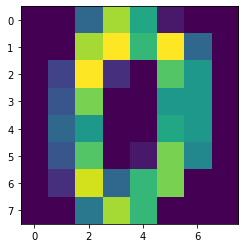

In [5]:
imshow(data_sample)

### Model Definition

Output size is equal to the input size, i.e., 64 units.

In [6]:
# Number of diffusion steps.
T = 100

In [7]:
# Won the race against ReLU.
ACTIVATION_FN = torch.nn.SiLU

In [11]:
class MuTheta(torch.nn.Module):
    def __init__(self, T: int):
        super().__init__()
        self.T = T
        self.mu_theta = torch.nn.Sequential(
            torch.nn.Linear(in_features=IMG_DIM+1, out_features=10),
            ACTIVATION_FN(),
            torch.nn.Linear(in_features=10, out_features=10),
            ACTIVATION_FN(),
            torch.nn.Linear(in_features=10, out_features=IMG_DIM))
        
    def forward(self, img: Tensor, t: int) -> Tensor:
        """img is a flat vector (possibly batched), t is a scalar"""
        t_scaled = self._scale_t(t)
        model_input = torch.concat([img, t_scaled], axis=-1)
        return self.mu_theta(model_input)
    
    def _scale_t(self, t: int) -> Tensor:
        return torch.tensor([(t / self.T - 0.5) * 2])

In [12]:
mu_theta = MuTheta(T=T)

Analyzing the deep image prior...

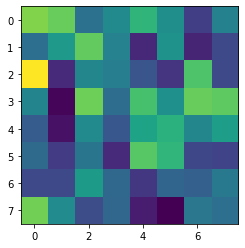

In [13]:
y = mu_theta(img=data_sample, t=0)
imshow(y.detach())

Paper values: $\beta_1=10^{-4}$ and $\beta_T=0.02$

In [29]:
beta_1 = 0.001
beta_T = 0.01

In [30]:
beta_t = torch.linspace(beta_1, beta_T, T)
alpha_t = 1 - beta_t
alpha_bar_t = torch.tensor([torch.prod(alpha_t[:s]) for s in range(1, T+1)])

def beta(t: int) -> float:
    assert 0 < t <= T
    return beta_t[t-1]

def alpha(t: int) -> float:
    assert 0 < t <= T
    return alpha_t[t-1]

def alpha_bar(t: int) -> float:
    if t == 0: return alpha_bar_t[0]
    assert 0 < t <= T
    return alpha_bar_t[t-1]

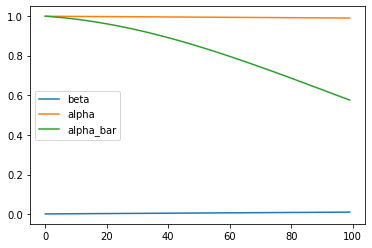

In [31]:
plt.plot(beta_t, label='beta')
plt.plot(alpha_t, label='alpha')
plt.plot(alpha_bar_t, label='alpha_bar')
plt.legend();

### Diffusion Process

(Aka. nosification.) **Eq. (4)** – the closed for of the iterative version in Eq. (2).

In [32]:
def q(x_0: Tensor, t: int) -> Tensor:
    """Implementatin of Eq. (4)."""
    std_normal = torch.randn(x_0.shape)
    mean = torch.sqrt(alpha_bar(t)) * x_0
    var = 1 - alpha_bar(t)
    return mean + std_normal * var.sqrt()

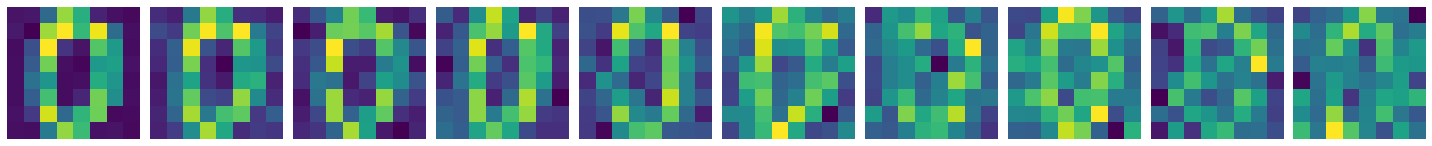

In [33]:
fig, ax = plt.subplots(1, 10, figsize=(20, 8))
ax = ax.flatten()

for i, t in enumerate(range(1, T, T // 10)):
    x_t = q(data_sample, t)
    
    ax[i].imshow(x_t.reshape((8, 8)))
    ax[i].axis('off')

plt.tight_layout()

### Reverse Process

(Aka. image generation.) The **term above Eq. (8)**, that is their implementation of Eq. (1). $\sigma$ is modeled as $=\beta$ (not a neural network).

They mention two possible choices for $\sigma_t^2$. We choose the simpler one.

In [34]:
sigma_squared_t = beta_t
sigma_squared = beta  # sigma_squared(t) = beta(t)

In [35]:
def p_theta(x_t: Tensor, t: int) -> Tensor:
    """p_theta(x_t-1|x_t)"""
    std_normal = torch.randn(x_t.shape)
    mu_theta_pred = mu_theta(img=x_t, t=t)
    var = sigma_squared(t)
    y = mu_theta_pred + std_normal * var.sqrt()
    return y

In [36]:
p_theta(x_t=data_sample, t=t)

tensor([ 0.3242,  0.1840, -0.0211, -0.0161,  0.1658, -0.0529, -0.2217, -0.1140,
        -0.1421,  0.1598,  0.1998, -0.1373, -0.2634,  0.0841, -0.1845, -0.2315,
         0.5753, -0.2910,  0.0156, -0.1166, -0.3847, -0.2292,  0.1899, -0.1901,
         0.0703, -0.4712,  0.3033, -0.0522,  0.1161,  0.0117,  0.1159,  0.2651,
        -0.1445, -0.4346,  0.1169, -0.1274,  0.0974,  0.2153, -0.1124,  0.2114,
        -0.2374, -0.2107, -0.1769, -0.3973,  0.2089,  0.2671, -0.2134, -0.1007,
         0.0385, -0.2862,  0.1820, -0.2301, -0.1392, -0.0437, -0.1497,  0.1462,
         0.3066,  0.0827, -0.2717, -0.0966, -0.4364, -0.1844, -0.0753, -0.0022],
       grad_fn=<AddBackward0>)

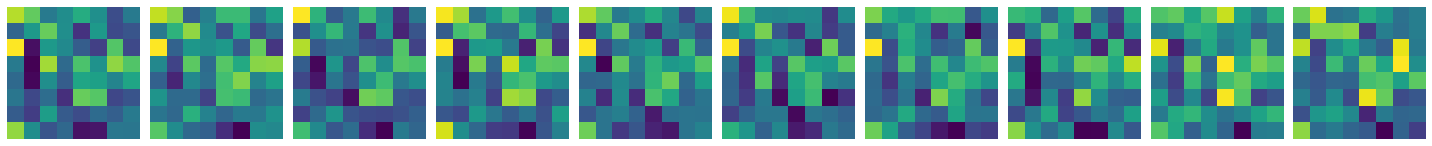

In [37]:
fig, ax = plt.subplots(1, 10, figsize=(20, 8))
ax = ax.flatten()

x_i = torch.randn(data_sample.shape)
for i, t in enumerate(range(1, T, T // 10)):
    x_i = p_theta(x_t=x_i, t=t).detach()
    
    ax[i].imshow(x_i.reshape((8, 8)))
    ax[i].axis('off')

plt.tight_layout()

### Loss Definition

Determining the mean $\tilde\mu_t$ of the diffusion process. **Eq. (7)**

In [38]:
def mu_tilde(x_t: Tensor, x_0: Tensor, t: int) -> Tensor:
    summand1 = (alpha_bar(t-1).sqrt() * beta(t)) / (1 - alpha_bar(t)) * x_0
    summand2 = (alpha(t).sqrt() * (1 - alpha_bar(t-1))) / (1 - alpha_bar(t)) * x_t
    return summand1 + summand2

**Equation above Eq. (9)**. Applying the reparameterization trick to sample from Eq. (4), i.e., $q_t(x_t\mid x_0)$.

In [39]:
def x_t(x_0: Tensor, t: int) -> Tensor:
    eps = torch.randn(x_0.shape)
    return alpha_bar(t).sqrt() + (1 - alpha_bar(t)).sqrt() * eps

In [40]:
mu_tilde(x_t(data_sample, 90), data_sample, 90)

tensor([ 1.1911, -0.0610,  1.1131,  1.3424,  1.3866,  0.7976,  0.1730,  0.6617,
         1.4470,  1.0413,  1.3325,  0.4615,  0.7754,  0.9197,  0.9799, -0.0670,
         0.3649,  0.5292, -0.8239,  1.8921,  0.3122,  0.3455,  1.2367,  1.3916,
         0.3133, -0.3117,  0.8735,  0.8995, -0.7384,  0.4271,  0.6299,  1.5714,
         0.6206, -0.1824,  0.5351,  1.1314, -0.3038,  0.9512,  0.7966,  0.6672,
         0.0651,  1.1681,  1.9826,  0.2500,  0.6628,  1.8468,  0.8341,  0.0714,
         1.6179,  1.0862,  0.7928,  0.5591,  1.2799,  1.8533, -0.5618,  1.3932,
         0.8906,  1.5917,  1.0822,  0.4917,  0.3470,  0.9699,  1.2401, -0.1552])

Loss function $L_{t-1}$ from **Eq. (8)**.

~~_Preferring the L2 norm over the Frobenius norm for computation efficiency._~~

In [41]:
def L(mu_tilde: Tensor, mu_theta: Tensor) -> Tensor:
    # Potentially risky (see "High Performance Python [Onomatopoeia], 2nd Edition")
    return 1 / (2 * sigma_squared(t)) * torch.linalg.norm(mu_tilde - mu_theta, ord=2) ** 2

In [42]:
NUM_MC_SAMPLES_X_T = 5
NUM_MC_SAMPLES_T = 10

def train_loss(net: torch.nn.Module, x_0: Tensor) -> Tensor:
    loss_sum = torch.tensor(0.)
    
    for t in torch.randint(1, T+1, size=(NUM_MC_SAMPLES_T,)):
        
        # Use multiple Monte Carlo samples to estimate the expected value over q in Eq. (8).
        loss_t_minus_1 = torch.tensor(0.)
        for _ in range(NUM_MC_SAMPLES_X_T):
            x_t_sample = x_t(x_0, t)
            mu_theta_val = net(img=x_t_sample, t=t)
            mu_tilde_val = mu_tilde(x_t_sample, x_0, t)
            l_tmp = L(mu_tilde_val, mu_theta_val)
            loss_t_minus_1 += l_tmp
        loss_sum += loss_t_minus_1 / NUM_MC_SAMPLES_X_T
        
    return loss_sum / NUM_MC_SAMPLES_T

### Training

In [66]:
NUM_EPOCHS = 100
LR = 1
WARM_START_EPOCHS = 10

torch.manual_seed(123)
mu_theta = MuTheta(T=T)

# Important update of Adam's beta_2 (might not work otherwise). ;-)
opt = torch.optim.Adam(mu_theta.parameters(), lr=1e-12, betas=(0.9, 0.996))
ll = []

for epoch in tqdm(range(1, NUM_EPOCHS+1)):
    opt.zero_grad()
    
    if epoch == WARM_START_EPOCHS:
        opt.param_groups[0]['lr'] = LR
    
    loss = torch.tensor(0.)
    for x_0 in data:
        loss += train_loss(mu_theta, x_0)
    loss /= len(data)
    ll.append(loss.item())
    
    loss.backward()
    opt.step()

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [03:37<00:00,  2.18s/it]


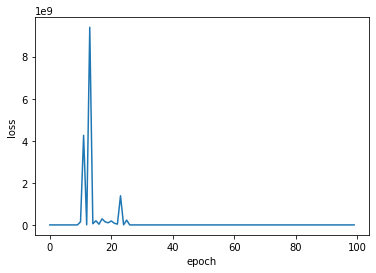

In [67]:
plt.plot(ll)
plt.xlabel('epoch')
plt.ylabel('loss');

### Inference

**Algorithm 2 (Sampling)** (except we predict $\mu$ not $\epsilon$)

In [59]:
x_i = torch.randn(data_sample.shape)
x_is = []
for i, t in tqdm(enumerate(range(T, 0, -1))):
    x_i = p_theta(x_t=x_i, t=t).detach()
    
    if t % 10 == 0:
        x_is.append(x_i.reshape((8, 8)))

100it [00:00, 12283.44it/s]


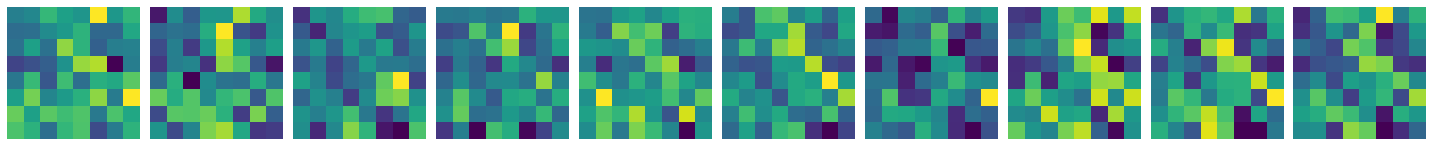

In [60]:
fig, ax = plt.subplots(1, len(x_is), figsize=(20, 8))
ax = ax.flatten()

for i, x_i in enumerate(x_is):
    ax[i].imshow(x_i)
    ax[i].axis('off')

plt.tight_layout()

### Todos

* Implement Algorithm 1 (and forget what we've done so far)
* Hparam tuning is tricky because our loss can be made arbitrarily (?) low by changing the betas.
* Data scaling